In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
import random
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# SEED
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
# Paths to image and metadata
# NOTE: Add your file paths for images AND csv below
img_dir = "C:/Users/mlasz/OneDrive/Desktop/mlm_25/biotrove_data/biotrove-clustering_unzipped/images/images"     
csv_path = "C:/Users/mlasz/OneDrive/Desktop/mlm_25/biotrove_data/biotrove-clustering_unzipped/metadata.csv"         

# Load metadata + sanity check assertions
df_meta = pd.read_csv(csv_path)
assert 'hash_id' in df_meta.columns, "CSV missing 'hash_id' column"
assert 'family' in df_meta.columns, "CSV missing 'family' column"

# Inspect metadata
print("Metadata preview:")
print(df_meta.head())

# Map images to csv filepaths
image_dir = Path(img_dir)
allowed_exts = {'.jpg', '.jpeg', '.png'}

# Index all images once (recursive, meaning: look into all directories and subdirectories)
all_paths = [p for p in image_dir.rglob("*") if p.suffix.lower() in allowed_exts]
print(f"Indexed {len(all_paths):,} image files")

# Build stem to list(paths) mapping
# Defaultdict(list) creates an empty list for new keys and '.append' adds the object 'p' as a string in that list for every path in our list 'all_paths'
stem_to_paths = defaultdict(list)
for p in all_paths:
    stem_to_paths[p.stem].append(str(p)) # p.stem is filepath without the extension (without jpeg, jpg, or png)

# Create a simple first-match dict (stem to first path)
# If images share a hashid, the first image "found" and connected to a hashid is kept
first_match = {stem: paths[0] for stem, paths in stem_to_paths.items()}

# Ensure hash_id is a string and has no whitespace by creating 'hash_id_str' column and adding to df_meta
df_meta['hash_id_str'] = df_meta['hash_id'].astype(str).str.strip()
# Create column for path for each hash_id and add to df_meta
df_meta['path'] = df_meta['hash_id_str'].map(first_match)  # NaN for missing
# show df_meta
print("Updated df_meta:")
print(df_meta.head())

# Create objects for: found metdata successfully linked image paths to hashids & object for unsucessfuly linked hashids
df_meta_found = df_meta[df_meta['path'].notna()].reset_index(drop=True)
hashid_to_path = dict(zip(df_meta_found['hash_id_str'], df_meta_found['path']))
missing_hashids = df_meta[df_meta['path'].isna()]['hash_id_str'].tolist()

# Print numbers of found and missing 
print(f"\nFound {len(hashid_to_path):,} matches; {len(missing_hashids):,} missing.")
if missing_hashids:
    print("Example missing ids:", missing_hashids[:5])

Metadata preview:
                    hash_id       family
0  223m6ywujk3htx2s3kfqx7ee  Acanthaceae
1  2aba7w224g4tso44mtzpnizg  Acanthaceae
2  2dovrj4uex7apou4zyu7nau7  Acanthaceae
3  2f53p6wsfhsnik2sy3jxn2ok  Acanthaceae
4  2fvqsa7ldatavhuevcvia5lm  Acanthaceae
Indexed 49,633 image files
Updated df_meta:
                    hash_id       family               hash_id_str  \
0  223m6ywujk3htx2s3kfqx7ee  Acanthaceae  223m6ywujk3htx2s3kfqx7ee   
1  2aba7w224g4tso44mtzpnizg  Acanthaceae  2aba7w224g4tso44mtzpnizg   
2  2dovrj4uex7apou4zyu7nau7  Acanthaceae  2dovrj4uex7apou4zyu7nau7   
3  2f53p6wsfhsnik2sy3jxn2ok  Acanthaceae  2f53p6wsfhsnik2sy3jxn2ok   
4  2fvqsa7ldatavhuevcvia5lm  Acanthaceae  2fvqsa7ldatavhuevcvia5lm   

                                                path  
0  C:\Users\mlasz\OneDrive\Desktop\mlm_25\biotrov...  
1  C:\Users\mlasz\OneDrive\Desktop\mlm_25\biotrov...  
2  C:\Users\mlasz\OneDrive\Desktop\mlm_25\biotrov...  
3  C:\Users\mlasz\OneDrive\Desktop\mlm_25\biotrov..

In [5]:
# Dataset and dataloader

# Image transforms - catered to ImageNet input data since ResNet models use pretrained ImageNet weights
img_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset
# Define FamilyDataset subclass
class FamilyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        with Image.open(row["path"]) as img:
            img = img.convert("RGB")
            if self.transform:
                img = self.transform(img)
        label = int(row["family_label"])
        return img, label

In [6]:
# ResNet50 2 layer extraction: layer 3 and global avg pool layer
class DualResNet50(nn.Module):
    def __init__(self, pretrained=True, proj_dim=128):
        super().__init__()
        from torchvision.models import resnet50, ResNet50_Weights

        # Use weights argument for pretrained
        weights = ResNet50_Weights.DEFAULT if pretrained else None
        base_model = resnet50(weights=weights)

        # Store the initial layers up to layer2
        self.initial_layers = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool,
            base_model.layer1,
            base_model.layer2
        )

        # Store layer3 and layer4 separately
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4
        self.avgpool = base_model.avgpool

        # Projection heads
        self.proj_genus = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, proj_dim)
        )
        self.proj_species = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, proj_dim)
        )

    def forward(self, x):
        # Initial layers
        x = self.initial_layers(x)  # up to layer2

        # Genus embeddings
        genus_feats = self.layer3(x)  # output 1024 channels
        genus_emb = F.adaptive_avg_pool2d(genus_feats, (1,1)).flatten(1)
        genus_emb = F.normalize(self.proj_genus(genus_emb), dim=1)

        # Species embeddings
        species_feats = self.layer4(genus_feats)  # input 1024 channels, output 2048 channels
        species_feats = self.avgpool(species_feats).flatten(1)
        species_emb = F.normalize(self.proj_species(species_feats), dim=1)

        return genus_emb, species_emb

In [7]:
# Supervised Contrastive learning loss calculation
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.12):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        labels = labels.contiguous().view(-1, 1)
        
        # Create mask of positive pairs
        mask = torch.eq(labels, labels.T).float().to(device)

        # Compute contrastive logits
        contrast = torch.div(torch.matmul(features, features.T), self.temperature)
        logits_max, _ = torch.max(contrast, dim=1, keepdim=True)
        logits = contrast - logits_max.detach()
        
        # Compute log-probabilities
        exp_logits = torch.exp(logits) * (1 - torch.eye(labels.shape[0], device=device))
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-8)

        # Safe computation of mean log-prob for positive pairs
        mask_sum = mask.sum(1)                 # number of positives for each sample
        mask_sum = torch.clamp(mask_sum, min=1)  # avoid division by zero
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_sum

        # Final loss
        loss = -mean_log_prob_pos.mean()
        return loss

In [8]:
def train_contrastive_amp(df_meta, epochs=10, lr=3e-4, proj_dim=128):
    # Map families to integers
    families = sorted(df_meta["family"].unique())
    family_to_idx = {fam: i for i, fam in enumerate(families)}
    df_meta["family_label"] = df_meta["family"].map(family_to_idx)

    # Transform: smaller crop to reduce memory
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    dataset = FamilyDataset(df_meta, transform)
    
    # Batch size reduced for 6GB VRAM
    loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)

    model = DualResNet50(pretrained=True, proj_dim=proj_dim).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = SupConLoss(temperature=0.07)

    scaler = GradScaler()
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for imgs, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.cuda(non_blocking=True), labels.cuda(non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with autocast():  # mixed precision forward
                genus_emb, species_emb = model(imgs)
                features = torch.cat([genus_emb, species_emb], dim=0)
                label_batch = torch.cat([labels, labels], dim=0)
                loss = criterion(features, label_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        torch.cuda.empty_cache()
        print(f"Epoch {epoch+1}/{epochs}: Loss = {total_loss/len(loader):.4f}")

    return model, family_to_idx

In [9]:
def extract_embeddings(model, df_meta):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    dataset = FamilyDataset(df_meta, transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()
    genus_embeds, species_embeds = [], []
    with torch.no_grad():
        for imgs, _ in tqdm(loader, desc="Extracting embeddings"):
            imgs = imgs.cuda()
            g_emb, s_emb = model(imgs)
            genus_embeds.append(g_emb.cpu())
            species_embeds.append(s_emb.cpu())
    return torch.cat(genus_embeds).numpy(), torch.cat(species_embeds).numpy()

In [10]:
# Call contrastive training and feature extractor function
df_meta_found["family_label"] = df_meta_found["family"].astype("category").cat.codes # precedes train_contrastive call
# Train contrastive supervised learning
model, fam_to_idx = train_contrastive_amp(df_meta_found, epochs=10)
# Extract features using trained contrastive learning model
genus_embeds, species_embeds = extract_embeddings(model, df_meta_found)

C:\Users\mlasz\AppData\Local\Temp\ipykernel_14756\1197681179.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/1552 [00:00<?, ?it/s]C:\Users\mlasz\AppData\Local\Temp\ipykernel_14756\1197681179.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision forward
Epoch 1/10: 100%|██████████| 1552/1552 [10:30<00:00,  2.46it/s]


Epoch 1/10: Loss = -2.6003


Epoch 2/10: 100%|██████████| 1552/1552 [10:37<00:00,  2.43it/s]


Epoch 2/10: Loss = -2.8015


Epoch 3/10: 100%|██████████| 1552/1552 [10:32<00:00,  2.45it/s]


Epoch 3/10: Loss = -2.9408


Epoch 4/10: 100%|██████████| 1552/1552 [10:37<00:00,  2.44it/s]


Epoch 4/10: Loss = -2.9939


Epoch 5/10: 100%|██████████| 1552/1552 [10:18<00:00,  2.51it/s]


Epoch 5/10: Loss = -3.0584


Epoch 6/10: 100%|██████████| 1552/1552 [10:24<00:00,  2.48it/s]


Epoch 6/10: Loss = -3.1027


Epoch 7/10: 100%|██████████| 1552/1552 [10:27<00:00,  2.47it/s]


Epoch 7/10: Loss = -3.0927


Epoch 8/10: 100%|██████████| 1552/1552 [10:39<00:00,  2.43it/s]


Epoch 8/10: Loss = -3.1810


Epoch 9/10: 100%|██████████| 1552/1552 [10:43<00:00,  2.41it/s]


Epoch 9/10: Loss = -3.1870


Epoch 10/10: 100%|██████████| 1552/1552 [10:47<00:00,  2.40it/s]


Epoch 10/10: Loss = -3.1863


Extracting embeddings: 100%|██████████| 1552/1552 [08:43<00:00,  2.96it/s]


C:\Users\mlasz\anaconda3\envs\biotrove\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


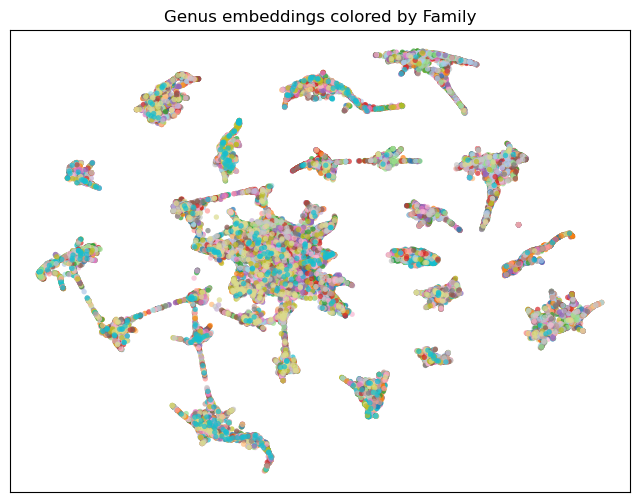

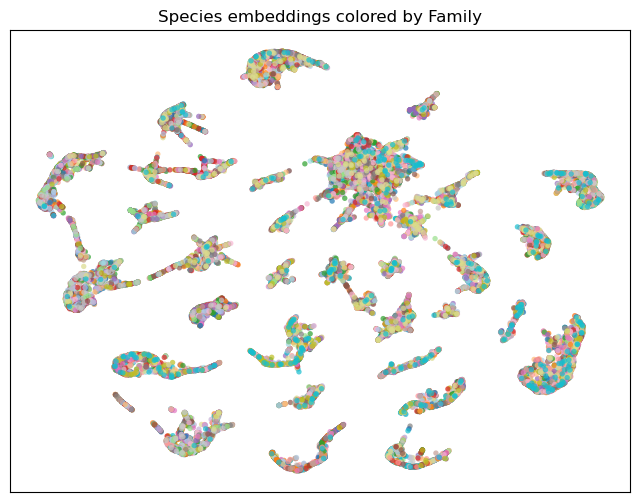

In [11]:
# Reduce to 2D for plotting
umap_2d = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, random_state=seed)
genus_2d = umap_2d.fit_transform(genus_embeds)
species_2d = umap_2d.fit_transform(species_embeds)

# Plot function
def plot_umap(coords, labels, title):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=labels, s=15, linewidth=0, alpha=0.7, palette="tab20")
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.legend([],[], frameon=False)
    plt.show()

# Optionally color by family
plot_umap(genus_2d, df_meta['family'], "Genus embeddings colored by Family")
plot_umap(species_2d, df_meta['family'], "Species embeddings colored by Family")